### Init


In [2]:
# Loading the libraries
from util import *
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
all_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_wine.csv', index_col=0)
errors = all_data['errors']
features = all_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

### Scaling the features

In [4]:
# Scaling all attributes
to_scale = features.columns
features[to_scale] = StandardScaler().fit_transform(features[to_scale])
features[:5]

# Scaling the errors
errors_col = MinMaxScaler(feature_range = (0,1.0)).fit_transform(all_data[['errors']])
scaling_factor = 0.8 #needs to be converted to scaling range
scaled_errors = scaling_factor * errors_col

### Utils

In [5]:
# TODO: experiment with different random states, increase number of runs
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2,
}


In [7]:
def plot_clusters(data):    
    scatterplot = sns.scatterplot(data=data, x="alcohol", y="ash", hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()
    
def accuracy(results):
    correct = results.loc[results['errors'] == 0]
    # print('Correct:', len(correct), ' -  Total:', len(results))
    acc = len(correct)/len(results)
    # print('Accuracy:', acc)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    return accuracy(remaining_clusters) - accuracy(cluster_x)

def bias_acc_towards_global_average(data, cluster_id, ave_acc):
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return ave_acc - accuracy(cluster_x)

def get_next_cluster(data):
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in range(0, n_cluster):
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def generate_variance_list(data, variance_list):
    for j in full_data['clusters'].unique():
        neg_bias_clus = bias_acc_towards_global_average(full_data, j, 'clusters', average_accuracy)
        neg_bias_list.append(neg_bias_clus)
    variance_clusters = np.var(neg_bias_list)
    variance_list.append(variance_clusters)
    return variance_clusters


## KMeans Clustering without errors as feature 

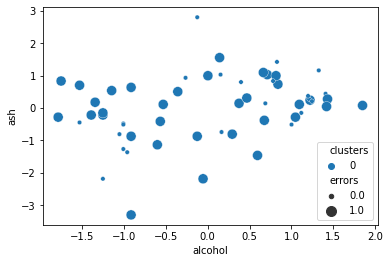

average_accuracy is:  0.40350877192982454
----- Clustering Iteration 1
Splitting on cluster 0


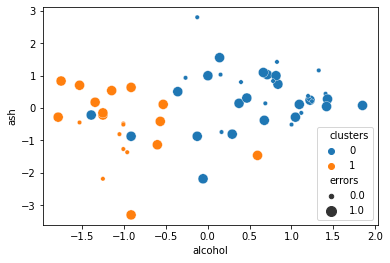

--> Cluster with the highest variance: 0
Variance clusters:  0.016584133842572943
----- Clustering Iteration 2
Splitting on cluster 0


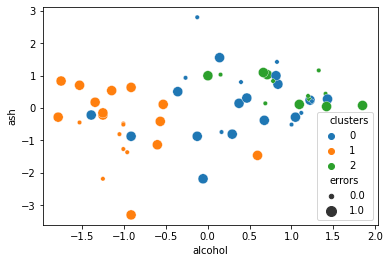

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
Variance clusters:  0.016584133842572943
----- Clustering Iteration 3
Splitting on cluster 1
Initial bias: 0.1748251748251748   -  Max abs. candidate bias: 0.08333333333333337
Min candidate size: 9
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.016584133842572943
----- Clustering Iteration 4
Splitting on cluster 0


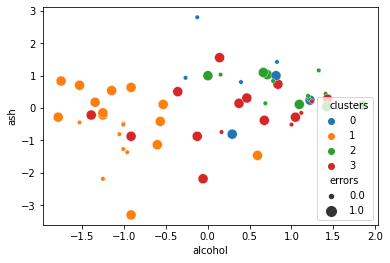

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 2
Variance clusters:  0.016584133842572943
----- Clustering Iteration 5
Splitting on cluster 2


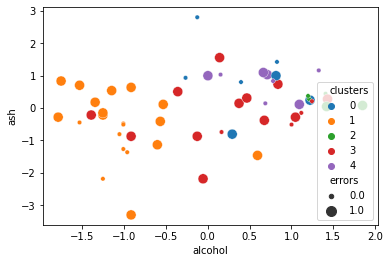

--> Cluster with the highest variance: 0
Variance clusters:  0.016584133842572943
----- Clustering Iteration 6
Splitting on cluster 0
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.016584133842572943
----- Clustering Iteration 7
Splitting on cluster 0
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.016584133842572943
----- Clustering Iteration 8
Splitting on cluster 2
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.016584133842572943
----- Clustering Iteration 9
Splitting on cluster 3


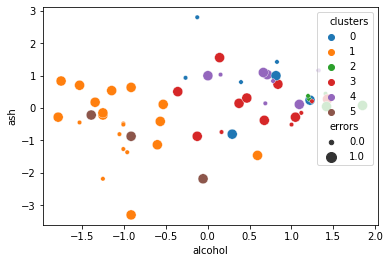

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 4
Variance clusters:  0.016584133842572943
----- Clustering Iteration 10
Splitting on cluster 4
Initial bias: 0.42592592592592593   -  Max abs. candidate bias: 0.27777777777777773
Min candidate size: 3
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.016584133842572943
----- Clustering Iteration 11
Splitting on cluster 0
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.016584133842572943
----- Clustering Iteration 12
Splitting on cluster 1
Initial bias: 0.42592592592592593   -  Max abs. candidate bias: 0.08333333333333337
Min candidate size: 9
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.016584133842572943
----- Clustering Iteration 13
Splitting on cluster 3
Initial bias: 0.42592592592592593   -  Max abs. candidate bias: 0.26470588235294124
Min candidate size: 6
The selected cluster is no

In [21]:
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list = []
average_accuracy = accuracy(full_data) 
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        generate_variance_list(full_data, variance_list) 
        print('Variance clusters: ', variance_clusters)
    print('----- Clustering Iteration', i)
    print('Splitting on cluster', x)

    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < 8:
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        continue
    
    # Apply Kmeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
        
    # calculate bias & cluster size for each of the two clusters
    negative_bias_0 = bias_acc(full_data, 0, 'new_clusters')
    negative_bias_1 = bias_acc(full_data, 1, 'new_clusters') 
    max_abs_bias = max(abs(negative_bias_0), abs(negative_bias_1))
    min_new_size = min( len(full_data.loc[full_data['new_clusters']==0]), len(full_data.loc[full_data['new_clusters']==1]) )
    
    if (max_abs_bias >= initial_bias) & (min_new_size > 1): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        print('Initial bias:', initial_bias, '  -  Max abs. candidate bias:', max_abs_bias)
        print('Min candidate size:', min_new_size)
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        
print('MAX_ITER')

print(variance_list)

### Analysing the clustering results


<AxesSubplot:ylabel='variance excl errors'>

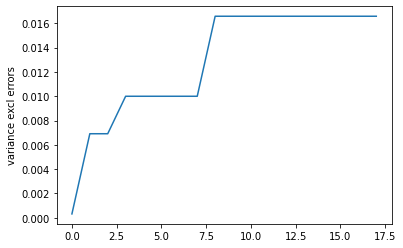

In [10]:
variance_df = pd.DataFrame(variance_list).rename(columns={0:"variance excl errors"})
sns.lineplot(data=variance_df, x=variance_df.index,y="variance excl errors")

## Bias-Aware Clustering with errors as attribute


In [11]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
# # Combine scaled features w. class & error labels
full_data = features.copy(deep=True)
full_data['true_class'] = all_data[['true_class']]
full_data['predicted_class'] = all_data[['predicted_class']]
full_data['errors'] = scaled_errors
full_data['clusters'] = 0
full_data['new_clusters'] = -1
full_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,true_class,predicted_class,errors,clusters,new_clusters
12,0.687846,-0.160373,0.141557,-0.694417,-0.834587,0.004312,0.267992,-0.318793,0.017405,0.697247,0.405843,-0.146241,1.256507,0.0,0,0.0,0,-1
23,-0.356751,-0.343481,0.502356,-0.101678,-0.381526,-0.222556,-0.278564,-0.635733,-0.650337,-0.367414,-0.033392,1.394286,0.408775,0.0,1,0.8,0,-1
25,-0.124619,0.290352,2.798346,2.269277,1.808272,0.061029,0.155878,1.582845,0.227267,-0.590546,0.259431,0.486852,-0.105424,0.0,0,0.0,0,-1
35,0.374467,-0.047692,0.141557,0.787430,-0.003974,0.193369,0.576306,-0.635733,0.112797,0.378486,-0.399421,1.056636,0.144727,0.0,1,0.8,0,-1
13,1.848509,-0.160373,0.075958,-2.209194,-0.683567,0.949596,1.571320,1.160258,1.925240,0.569743,1.137900,-0.504994,0.784001,0.0,2,0.8,0,-1


In [14]:
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list_errors = []

for i in range(1, MAX_ITER):
    if i != 1:
        generate_variance_list(full_data, variance_list) 
        print('Variance clusters: ', variance_clusters)
    print('----- Clustering Iteration', i)
    print('Splitting on cluster', x)

    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < 8:
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        initial_bias = abs(bias_acc(full_data, x, 'clusters'))
        continue
    
    # Apply Kmeans 
    kmeans_algo = (**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class'], axis=1)),index=candidate_cluster.index) 
    # print(candidate_cluster.head())

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
    # print(full_data.head())
        
    # calculate bias & cluster size for each of the two clusters
    negative_bias_0 = bias_acc(full_data, 0, 'new_clusters')
    negative_bias_1 = bias_acc(full_data, 1, 'new_clusters') 
    max_abs_bias = max(abs(negative_bias_0), abs(negative_bias_1))
    min_new_size = min( len(full_data.loc[full_data['new_clusters']==0]), len(full_data.loc[full_data['new_clusters']==1]) )
    
    if (max_abs_bias >= initial_bias) & (min_new_size > 1): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        plot_clusters(full_data)

        x = get_next_cluster(full_data)
        initial_bias = abs(bias_acc(full_data, x, 'clusters'))
    else:
        print('Initial bias:', initial_bias, '  -  Max abs. candidate bias:', max_abs_bias)
        print('Min candidate size:', min_new_size)
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        initial_bias = abs(bias_acc(full_data, x, 'clusters'))
        
print('MAX_ITER')
print(variance_list_errors)

SyntaxError: invalid syntax (<ipython-input-14-5773d47d3db1>, line 31)

### Analysing the clustering results

,variance incl errors,variance without errors
0,0.001276,0.001276
1,0.028141,0.013285
2,0.028141,0.011611
3,0.022544,0.013861
4,0.022544,0.012421
5,0.018882,0.012421
6,0.018882,0.012421
7,0.037656,0.017917
8,0.037656,0.017917
9,0.035387,0.017917


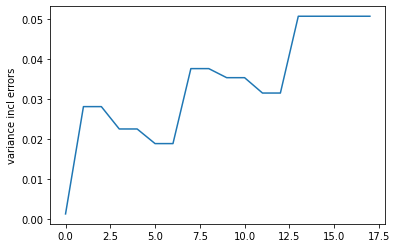

In [72]:
variance_errors = pd.DataFrame(variance_list_errors).rename(columns={0:"variance incl errors"})
sns.lineplot(data=variance_errors, x=variance_errors.index,y="variance incl errors")
# variance_errors['with errors'] = variance_errors
variance_errors['variance without errors'] = variance_df[['variance excl errors']]
# needs to be fixed
variance_errors

Text(0.5, 0, 'Iterations')

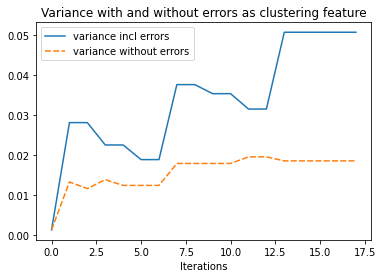

In [86]:
import matplotlib.pyplot as plt
fig = sns.lineplot(data=variance_errors).set_title('Variance with and without errors as clustering feature')
plt.xlabel('Iterations')
# plt.ylabel('Bias')


## Bias-Aware DBSCAN

In [35]:
# Combine scaled features w. class & error labels
full_data = features.copy(deep=True)
full_data['true_class'] = all_data[['true_class']]
full_data['predicted_class'] = all_data[['predicted_class']]
full_data['errors'] = all_data[['errors']]
full_data['clusters'] = 0
full_data['new_clusters'] = -1
full_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,true_class,predicted_class,errors,clusters,new_clusters
12,0.687846,-0.160373,0.141557,-0.694417,-0.834587,0.004312,0.267992,-0.318793,0.017405,0.697247,0.405843,-0.146241,1.256507,0.0,0,0.0,0,-1
23,-0.356751,-0.343481,0.502356,-0.101678,-0.381526,-0.222556,-0.278564,-0.635733,-0.650337,-0.367414,-0.033392,1.394286,0.408775,0.0,1,1.0,0,-1
25,-0.124619,0.290352,2.798346,2.269277,1.808272,0.061029,0.155878,1.582845,0.227267,-0.590546,0.259431,0.486852,-0.105424,0.0,0,0.0,0,-1
35,0.374467,-0.047692,0.141557,0.787430,-0.003974,0.193369,0.576306,-0.635733,0.112797,0.378486,-0.399421,1.056636,0.144727,0.0,1,1.0,0,-1
13,1.848509,-0.160373,0.075958,-2.209194,-0.683567,0.949596,1.571320,1.160258,1.925240,0.569743,1.137900,-0.504994,0.784001,0.0,2,1.0,0,-1


In [ ]:
def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return ave_acc - accuracy(cluster_x)

MAX_ITER = 20
epsilon = 3
minimum_samples = 2 
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list = []
average_accuracy = accuracy(full_data) 
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        neg_bias_list = []
        for j in full_data['clusters'].unique():
            neg_bias_clus = bias_acc_towards_global_average(full_data, j, 'clusters', average_accuracy)
            neg_bias_list.append(neg_bias_clus)
        variance_clusters = np.var(neg_bias_list)
        variance_list.append(variance_clusters) #TODO make function 
        print('Variance clusters: ', variance_clusters)
    print('----- Clustering Iteration', i)
    print('Splitting on cluster', x)

    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < 8:
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        # initial_bias = abs(bias_acc_towards_global_average(full_data, x, average_accuracy)) #threshold 
        continue
     
    dbscan_algo = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(dbscan_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    # print(candidate_cluster.head())

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
    # print(full_data.head())
        
    # calculate bias & cluster size for each of the two clusters
    negative_bias_0 = bias_acc(full_data, 0, 'new_clusters')
    negative_bias_1 = bias_acc(full_data, 1, 'new_clusters') 
    max_abs_bias = max(abs(negative_bias_0), abs(negative_bias_1))
    min_new_size = min( len(full_data.loc[full_data['new_clusters']==0]), len(full_data.loc[full_data['new_clusters']==1]) )
    
    if (max_abs_bias >= initial_bias) & (min_new_size > 1): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        #print(full_data.head())
        
        plot_clusters(full_data)

        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        print('Initial bias:', initial_bias, '  -  Max abs. candidate bias:', max_abs_bias)
        print('Min candidate size:', min_new_size)
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        # initial_bias = abs(bias_acc(full_data, x, 'clusters'))
        
print('MAX_ITER')

print(variance_list)

## DBSCAN without recursivity

In [ ]:
var_list = []
epsilon = 3
minimum_samples = 2
features_i = features.copy(deep=True)
features_i["errors"] = errors

for n in range(2, 58):
    model = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(features_i)
    features_i['cluster_results'] = pd.DataFrame(model, index=features_i.index)

    neg_bias_list = []
    epsilon = epsilon-0.1
    if  len(features_i["cluster_results"].unique()) == 1:
        print("One cluster left on iteration ", n)
        print("With epsilon", epsilon)
        break
    for i in features_i["cluster_results"].unique():
        print(features_i["cluster_results"].unique())
        #print('features_i', features_i)
        neg_bias_list.append(bias_acc(features_i, i,"cluster_results"))
    var_list.append(np.var(neg_bias_list))
print(var_list)

plt.plot(var_list)

## Same conditions but then with Mean Shift as clustering algorithm


In [18]:
from sklearn.cluster import MeanShift, estimate_bandwidth

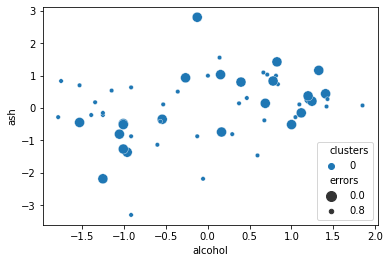

----- Clustering Iteration 1
Splitting on cluster 0
Initial bias: 0   -  Max abs. candidate bias: 0.4107142857142857
Min candidate size: 1
The selected cluster is not splitted. Picking a random cluster...


ZeroDivisionError: division by zero

In [19]:
# bw1 = estimate_bandwidth(features_i)
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list_errors = []

for i in range(1, MAX_ITER):
    if i != 1:
        neg_bias_list = []
        for j in full_data['clusters'].unique():
            neg_bias_clus = bias_acc(full_data, j, 'clusters')
            neg_bias_list.append(neg_bias_clus)
        variance_clusters = np.var(neg_bias_list)
        variance_list_errors.append(variance_clusters) #TODO make function 
        print('Variance clusters: ', variance_clusters)
    print('----- Clustering Iteration', i)
    print('Splitting on cluster', x)

    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 
    #print(candidate_cluster.head())

    if len(candidate_cluster) < 8:
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        initial_bias = abs(bias_acc(full_data, x, 'clusters'))
        continue
    
    # Apply Kmeans 
    meanshift_algo = MeanShift(bandwidth=0.5).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(meanshift_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class'], axis=1)),index=candidate_cluster.index) 
    # print(candidate_cluster.head())

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
    # print(full_data.head())
        
    # calculate bias & cluster size for each of the two clusters
    negative_bias_0 = bias_acc(full_data, 0, 'new_clusters')
    negative_bias_1 = bias_acc(full_data, 1, 'new_clusters') 
    max_abs_bias = max(abs(negative_bias_0), abs(negative_bias_1))
    min_new_size = min( len(full_data.loc[full_data['new_clusters']==0]), len(full_data.loc[full_data['new_clusters']==1]) )
    
    if (max_abs_bias >= initial_bias) & (min_new_size > 1): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        #print(full_data.head())
        
        plot_clusters(full_data)

        x = get_next_cluster(full_data)
        initial_bias = abs(bias_acc(full_data, x, 'clusters'))
    else:
        print('Initial bias:', initial_bias, '  -  Max abs. candidate bias:', max_abs_bias)
        print('Min candidate size:', min_new_size)
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        initial_bias = abs(bias_acc(full_data, x, 'clusters'))
        
print('MAX_ITER')
print(variance_list_errors)

In [18]:
# exporting the biased cluster dataframe for further analysis
import os
path = r'..\\Clustered_datasets\\'
# full_data.to_csv(os.path.join(path, r'biased_wine_clusters.csv'))
